In [1]:
import numpy as np
import pandas as pd
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# import trackpy as tp
from skimage.filters import gaussian

In [2]:
img = AICSImage('/allen/aics/assay-dev/users/Sandi/pair-up/anthonya/live-cells/modifeid.tiff')
img.shape

(188, 2, 5, 1024, 1024)

# TrackPy test

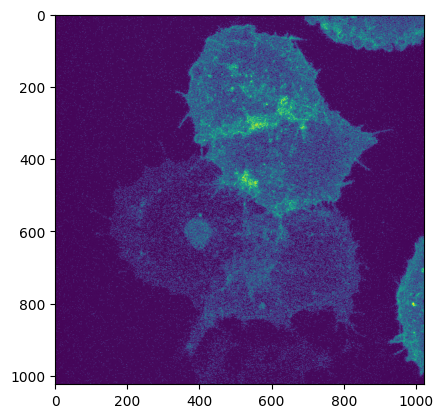

In [3]:
frames = np.max(img.data, axis=2)
# frames = gaussian(frames, 1)

import matplotlib.pyplot as plt
plt.imshow(frames[20,1])

In [4]:
# for t in range(0, frames.shape[0], 10):
#     f = tp.locate(frames[t], 31, invert=False)
#     tp.annotate(f, frames[t])

In [5]:
# f = tp.locate(frames, 31, invert=False)
# t = tp.link(f, 15, memory=3)

# Motion Correction - skimage

In [6]:
from skimage.registration import phase_cross_correlation
from skimage.exposure import rescale_intensity

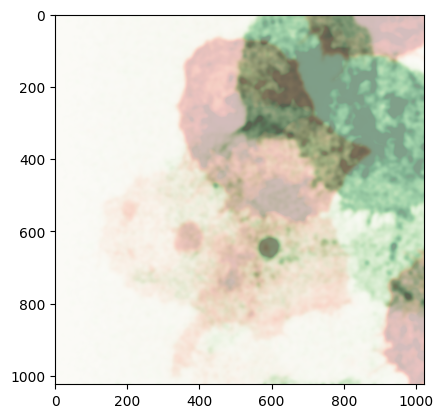

In [7]:
frame1 = gaussian(frames[0,1], 5)
frame2 = gaussian(frames[180,1], 5)

p5, p95 = np.percentile(frame1, (5, 95))
frame1 = np.clip(frame1, p5, p95)
frame1 = rescale_intensity(frame1, out_range=np.uint8)

p5, p95 = np.percentile(frame2, (5, 95))
frame2 = np.clip(frame2, p5, p95)
frame2 = rescale_intensity(frame2, out_range=np.uint8)

plt.figure()
plt.imshow(frame1, cmap='Reds', alpha=0.5)
plt.imshow(frame2, cmap='Greens', alpha=0.5)

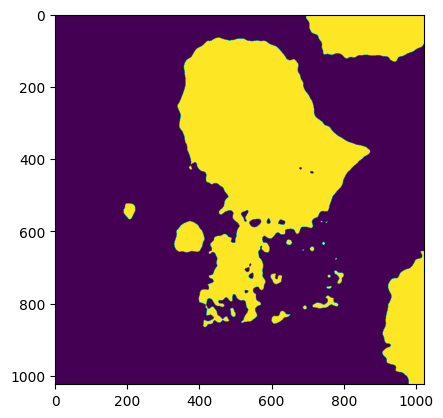

In [8]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(frame1)
binary = frame1 > thresh

plt.figure()
plt.imshow(binary)

[ 148. -142.]


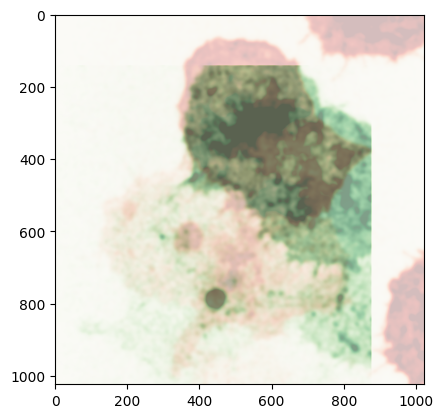

In [9]:
shift, _, _ = phase_cross_correlation(
    frame1, 
    frame2, 
    upsample_factor=20,
    reference_mask=binary,
)
print(shift)

from skimage.transform import warp, SimilarityTransform
tform = SimilarityTransform(translation=(shift[0], shift[1]))
frame2_shift = warp(frame2, tform)

plt.figure()
plt.imshow(frame1, cmap='Reds', alpha=0.5)
plt.imshow(frame2_shift, cmap='Greens', alpha=0.5)

In [10]:
from tqdm import tqdm
from skimage.morphology import binary_dilation, disk, remove_small_objects, remove_small_holes

def segment(img):
    p5, p95 = np.percentile(img, (5, 95))
    img = np.clip(img, p5, p95)
    img = rescale_intensity(img, out_range=np.uint8)
    
    thresh = threshold_otsu(img)
    binary = img > thresh
    
    binary = remove_small_objects(binary, 100)
    binary = remove_small_holes(binary, 500)
    binary = binary_dilation(binary, disk(15))
    
    return binary

def correct_motion(sequence, kernel_size=11, refresh=25):
    seq_smoothed = np.zeros_like(sequence, dtype=np.uint16)
    seq_smoothed[0] = sequence[0]
    
    reference = gaussian(sequence[0], kernel_size)
    ref_bin = segment(reference)
    
    shifts = []
    for t in tqdm(range(1, sequence.shape[0])):
        if t % refresh == 0:
            reference = gaussian(seq_smoothed[t-1], kernel_size)
            ref_bin = segment(reference)
        
        moving = gaussian(sequence[t], kernel_size)
        mov_bin = segment(moving)
        
        reference = rescale_intensity(reference, out_range=np.uint16)
        moving = rescale_intensity(moving, out_range=np.uint16)
        
        shift, _, _ = phase_cross_correlation(
            reference, 
            moving, 
            upsample_factor=20,
            reference_mask=ref_bin,
            moving_mask=mov_bin,
        )
        shifts.append(shift)
        tform = SimilarityTransform(translation=(shift[0], shift[1]))
        seq_smoothed[t] = rescale_intensity(
            warp(sequence[t], tform, preserve_range=True),
            out_range=np.uint16
        )
        
    return seq_smoothed, np.stack(shifts, axis=0)

In [11]:
smooth_frames, shifts = correct_motion(frames[:,1,...])

100%|██████████| 187/187 [05:28<00:00,  1.76s/it]


In [12]:
# from aicsimageio.writers import OmeTiffWriter

# OmeTiffWriter.save(smooth_frames, 'smoothed.tiff')

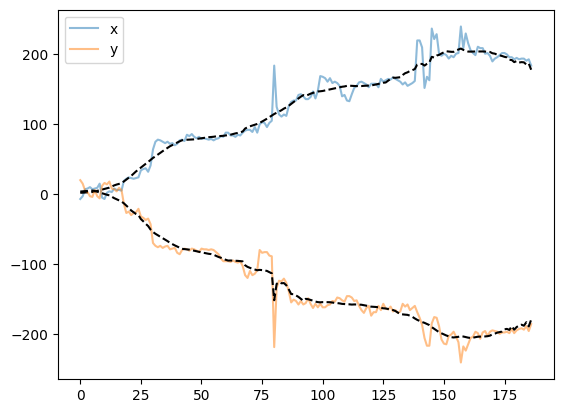

In [13]:
from scipy.signal import wiener

plt.figure()
plt.plot(shifts[:,0], label='x', alpha=0.5)
plt.plot(wiener(shifts[:,0], 25), 'k--')
plt.plot(shifts[:,1], label='y', alpha=0.5)
plt.plot(wiener(shifts[:,1], 25), 'k--')
plt.legend()

In [14]:
shifts_smooths = np.stack([
    wiener(shifts[:,0], 25),
    wiener(shifts[:,1], 25)
], axis=1)

data_smoothed = np.zeros_like(img.data, dtype=np.uint16)
dmin = img.data.min()
dmax = img.data.max()
for t in tqdm(range(img.data.shape[0])):
    if t == 0:
        data_smoothed[t] = rescale_intensity(img.data[t], out_range=(dmin, dmax))
        continue
    tform = SimilarityTransform(translation=(shifts_smooths[t-1,0], shifts_smooths[t-1,1]))
    for z in range(img.data.shape[2]):
        for c in range(img.data.shape[1]):
            data_smoothed[t,c,z,...] = rescale_intensity(
                warp(img.data[t,c,z,...], tform, preserve_range=True, order=0),
                out_range=(dmin, dmax)
            )

100%|██████████| 188/188 [02:42<00:00,  1.16it/s]


In [15]:
OmeTiffWriter.save(data_smoothed, 'results/data_smoothed.tiff')
OmeTiffWriter.save(data_smoothed[:,1,...], 'results/data_smoothed_green.tiff')
OmeTiffWriter.save(data_smoothed[:,0,...], 'results/data_smoothed_red.tiff')

## TrackPy test

In [16]:
# frames = np.max(data_smoothed[:,0,...], axis=1)
# for t in range(0, frames.shape[0], 10):
#     frames[t] = gaussian(frames[t], 5, preserve_range=True)
# frames = rescale_intensity(frames, out_range=(0,1))
# frames.shape

In [17]:
# for t in range(0, frames.shape[0], 25):
#     f = tp.locate(frames[t], 31, invert=False, minmass=5)
#     tp.annotate(f, frames[t])

In [18]:
# f = tp.batch(frames, 31, invert=False, minmass=60)
# f.head()

In [19]:
# t = tp.link(f, 20, memory=3)
# t = tp.filter_stubs(t, 5)

In [20]:
# tp.plot_traj(t)

In [21]:
# d = tp.compute_drift(t)
# d.plot()
# plt.show()

In [22]:
# tm = tp.subtract_drift(t.copy(), d)

# ax=tp.plot_traj(tm)
# plt.show()

## Segmentation

In [23]:
from skimage.segmentation import morphological_chan_vese, morphological_geodesic_active_contour
from skimage.morphology import ball
from skimage.feature import blob_dog as blob

def graph_iteration(levelset):
    fig, ax = plt.subplots()
    ax.imshow(data_smoothed[0,0,2,...], cmap='gray')
    ax.contour(levelset[2,...], [0.5], colors='r')
    plt.show()

def segment(img, display=False):
    points = blob(img, min_sigma=1, max_sigma=10, threshold=0.1)
    init_blob = np.zeros(img.shape, dtype=np.uint8) 
    for n in range(points.shape[0]):
        pt = points[n, ...]
        init_blob[int(pt[0]), int(pt[1]), int(pt[2])] = 1
    init_blob = binary_dilation(init_blob, ball(7))
    
    init_otsu = img > threshold_otsu(img)
    init_otsu = remove_small_objects(init_otsu, 20)
    init_otsu = binary_dilation(init_otsu, ball(3))
    
    init = np.logical_or(init_blob, init_otsu)
    
    return init, morphological_chan_vese(
        rescale_intensity(img, out_range=(0,1)), 
        10,
        lambda1=1,
        lambda2=1.25,
        init_level_set=init
    )

In [24]:
tp = 50
test_img = data_smoothed[tp,0,...]
print(test_img.shape)

init, seg = segment(test_img)
# seg = remove_small_objects(seg, 10)

(5, 1024, 1024)


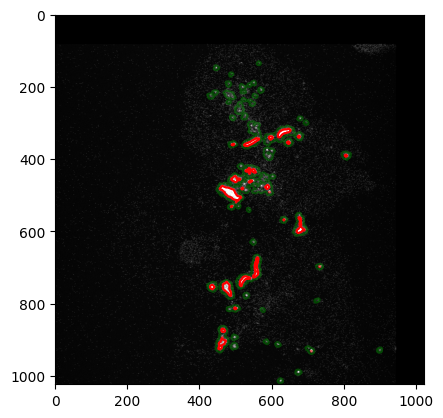

In [25]:
plt.figure()
plt.imshow(np.max(test_img, axis=0), cmap='gray')
plt.contour(np.max(init, axis=0), [0.5], colors='g', alpha=0.5)
plt.contour(np.max(seg, axis=0), [0.5], colors='r')

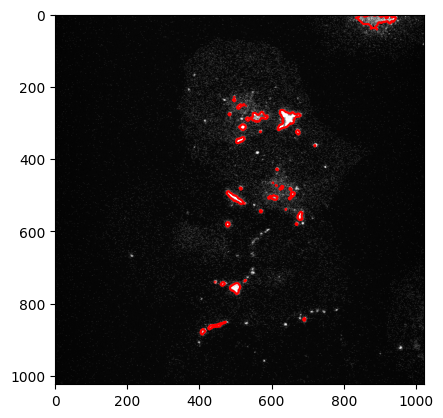

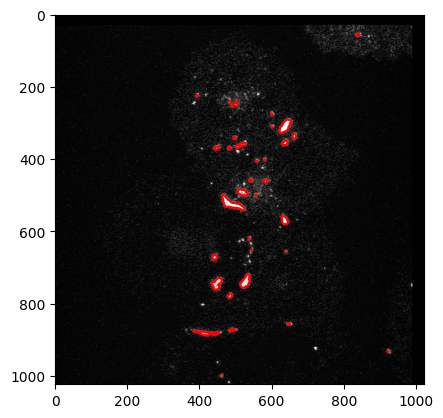

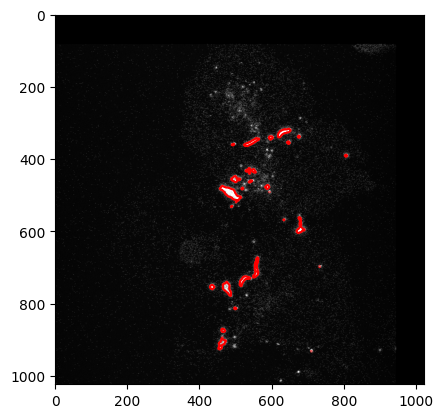

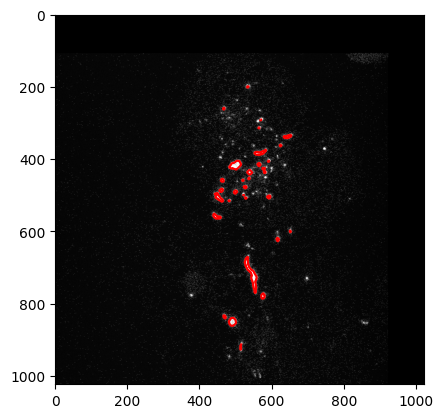

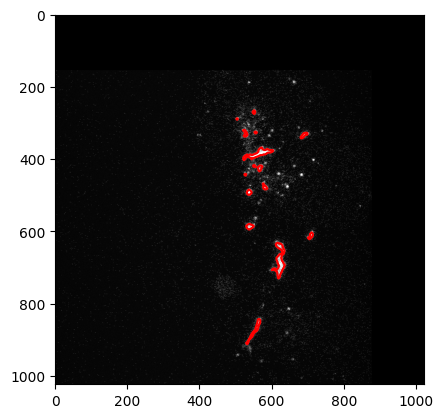

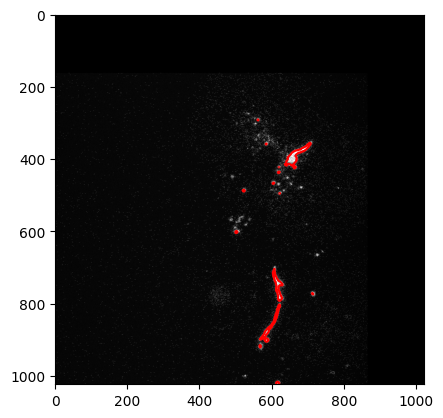

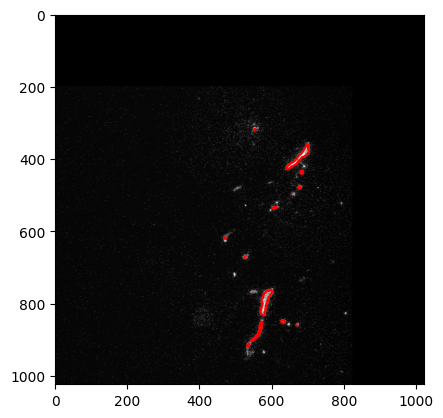

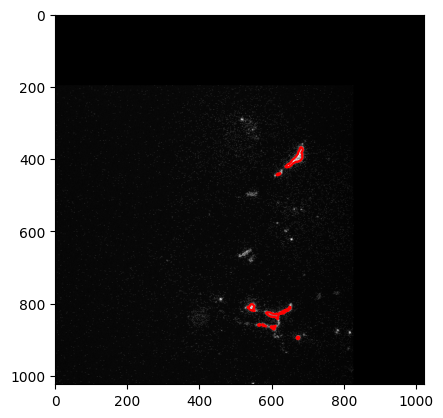

In [26]:
for t in range(0, data_smoothed.shape[0], 25):
    init, seg = segment(data_smoothed[t,0,...])
    plt.figure()
    plt.imshow(np.max(data_smoothed[t,0,...], axis=0), cmap='gray')
    # plt.contour(np.max(init, axis=0), [0.5], colors='g', alpha=0.5)
    plt.contour(np.max(seg, axis=0), [0.5], colors='r')

In [27]:
# segmented = np.zeros_like(data_smoothed[:,0,...], dtype=np.uint8)
# for t in tqdm(range(data_smoothed.shape[0])):
#     _, segmented[t] = segment(data_smoothed[t,0,...])
    
# OmeTiffWriter.save(segmented, 'results/segmented.tiff')

In [28]:
# from skimage.measure import label

# seg_lbl = np.zeros_like(segmented, dtype=np.uint16)
# for t in tqdm(range(segmented.shape[0])):
#     seg_lbl[t] = label(segmented[t])
# OmeTiffWriter.save(seg_lbl, 'results/segmented_lbl.tiff')

## Segment AICS-Seg

In [29]:
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d, edge_preserving_smoothing_3d
from skimage.morphology import remove_small_objects 
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper 
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.measure import label

In [30]:
def segment_aics(img):
    intensity_scaling_param = [8000]
    gaussian_smoothing_sigma = 1

    # intensity normalization
    struct_img = intensity_normalization(img, scaling_param=intensity_scaling_param)

    # smoothing with gaussian filter
    structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)
    
    ## PARAMETERS for this step ##
    s3_param = [[2, 0.06]] # original: [[1, 0.04]], current: [[2, 0.06]]
    ################################

    bw = dot_3d_wrapper(structure_img_smooth, s3_param)
    
    # post-processing
    minArea = 20 # current: 20 
    ################################

    seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1)
    
    out=seg.astype(np.uint8)
    out[out>0]=255
    
    return label(out)

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


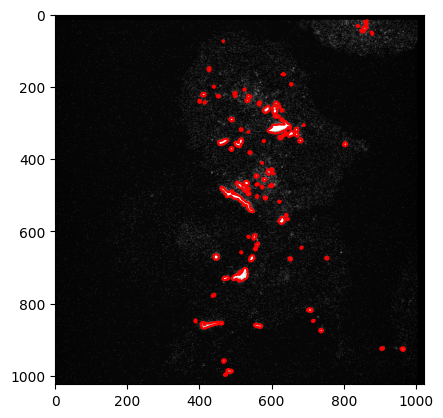

In [31]:
seg = segment_aics(data_smoothed[20,0,...])

plt.figure()
plt.imshow(np.max(data_smoothed[20,0,...], axis=0), cmap='gray')
plt.contour(np.max(seg, axis=0), [0.5], colors='r')

In [32]:
segmented = np.zeros_like(data_smoothed[:,0,...], dtype=np.uint16)
for t in tqdm(range(data_smoothed.shape[0])):
    segmented[t] = segment_aics(data_smoothed[t,0,...])
    
OmeTiffWriter.save(segmented, 'results/segmented_aics.tiff', dim_order='TZYX')

  0%|          | 0/188 [00:00<?, ?it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  1%|          | 1/188 [00:00<01:52,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  1%|          | 2/188 [00:01<01:50,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  2%|▏         | 3/188 [00:01<01:49,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  2%|▏         | 4/188 [00:02<01:50,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  3%|▎         | 5/188 [00:02<01:49,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  3%|▎         | 6/188 [00:03<01:47,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  4%|▎         | 7/188 [00:04<01:47,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  4%|▍         | 8/188 [00:04<01:47,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  5%|▍         | 9/188 [00:05<01:46,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  5%|▌         | 10/188 [00:05<01:45,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  6%|▌         | 11/188 [00:06<01:44,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  6%|▋         | 12/188 [00:07<01:44,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  7%|▋         | 13/188 [00:07<01:43,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  7%|▋         | 14/188 [00:08<01:43,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  8%|▊         | 15/188 [00:08<01:42,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  9%|▊         | 16/188 [00:09<01:42,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


  9%|▉         | 17/188 [00:10<01:41,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 10%|▉         | 18/188 [00:10<01:41,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 10%|█         | 19/188 [00:11<01:41,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 11%|█         | 20/188 [00:11<01:39,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 11%|█         | 21/188 [00:12<01:39,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 12%|█▏        | 22/188 [00:13<01:38,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 12%|█▏        | 23/188 [00:13<01:37,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 13%|█▎        | 24/188 [00:14<01:37,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 13%|█▎        | 25/188 [00:14<01:37,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 14%|█▍        | 26/188 [00:15<01:36,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 14%|█▍        | 27/188 [00:16<01:36,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 15%|█▍        | 28/188 [00:16<01:35,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 15%|█▌        | 29/188 [00:17<01:34,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 16%|█▌        | 30/188 [00:17<01:34,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 16%|█▋        | 31/188 [00:18<01:33,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 17%|█▋        | 32/188 [00:19<01:33,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 18%|█▊        | 33/188 [00:19<01:33,  1.65it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 18%|█▊        | 34/188 [00:20<01:33,  1.65it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 19%|█▊        | 35/188 [00:20<01:33,  1.64it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 19%|█▉        | 36/188 [00:21<01:31,  1.65it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 20%|█▉        | 37/188 [00:22<01:30,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 20%|██        | 38/188 [00:22<01:30,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 21%|██        | 39/188 [00:23<01:29,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 21%|██▏       | 40/188 [00:23<01:29,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 22%|██▏       | 41/188 [00:24<01:28,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 22%|██▏       | 42/188 [00:25<01:26,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 23%|██▎       | 43/188 [00:25<01:26,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 23%|██▎       | 44/188 [00:26<01:25,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 24%|██▍       | 45/188 [00:26<01:24,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 24%|██▍       | 46/188 [00:27<01:24,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 25%|██▌       | 47/188 [00:28<01:24,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 26%|██▌       | 48/188 [00:28<01:24,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 26%|██▌       | 49/188 [00:29<01:23,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 27%|██▋       | 50/188 [00:29<01:23,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 27%|██▋       | 51/188 [00:30<01:22,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 28%|██▊       | 52/188 [00:31<01:21,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 28%|██▊       | 53/188 [00:31<01:21,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 29%|██▊       | 54/188 [00:32<01:19,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 29%|██▉       | 55/188 [00:32<01:18,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 30%|██▉       | 56/188 [00:33<01:18,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 30%|███       | 57/188 [00:34<01:17,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 31%|███       | 58/188 [00:34<01:17,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 31%|███▏      | 59/188 [00:35<01:16,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 32%|███▏      | 60/188 [00:35<01:16,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 32%|███▏      | 61/188 [00:36<01:16,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 33%|███▎      | 62/188 [00:37<01:15,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 34%|███▎      | 63/188 [00:37<01:14,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 34%|███▍      | 64/188 [00:38<01:13,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 35%|███▍      | 65/188 [00:38<01:13,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 35%|███▌      | 66/188 [00:39<01:12,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 36%|███▌      | 67/188 [00:40<01:11,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 36%|███▌      | 68/188 [00:40<01:11,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 37%|███▋      | 69/188 [00:41<01:10,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 37%|███▋      | 70/188 [00:41<01:10,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 38%|███▊      | 71/188 [00:42<01:09,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 38%|███▊      | 72/188 [00:42<01:09,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 39%|███▉      | 73/188 [00:43<01:08,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 39%|███▉      | 74/188 [00:44<01:07,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 40%|███▉      | 75/188 [00:44<01:07,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 40%|████      | 76/188 [00:45<01:06,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 41%|████      | 77/188 [00:45<01:05,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 41%|████▏     | 78/188 [00:46<01:04,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 42%|████▏     | 79/188 [00:47<01:04,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 43%|████▎     | 80/188 [00:47<01:04,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 43%|████▎     | 81/188 [00:48<01:03,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 44%|████▎     | 82/188 [00:48<01:03,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 44%|████▍     | 83/188 [00:49<01:02,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 45%|████▍     | 84/188 [00:50<01:02,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 45%|████▌     | 85/188 [00:50<01:01,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 46%|████▌     | 86/188 [00:51<01:00,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 46%|████▋     | 87/188 [00:51<01:00,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 47%|████▋     | 88/188 [00:52<00:59,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 47%|████▋     | 89/188 [00:53<00:58,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 48%|████▊     | 90/188 [00:53<00:58,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 48%|████▊     | 91/188 [00:54<00:57,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 49%|████▉     | 92/188 [00:54<00:57,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 49%|████▉     | 93/188 [00:55<00:56,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 50%|█████     | 94/188 [00:56<00:55,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 51%|█████     | 95/188 [00:56<00:54,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 51%|█████     | 96/188 [00:57<00:54,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 52%|█████▏    | 97/188 [00:57<00:53,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 52%|█████▏    | 98/188 [00:58<00:53,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 53%|█████▎    | 99/188 [00:59<00:52,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 53%|█████▎    | 100/188 [00:59<00:52,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 54%|█████▎    | 101/188 [01:00<00:51,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 54%|█████▍    | 102/188 [01:00<00:50,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 55%|█████▍    | 103/188 [01:01<00:50,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 55%|█████▌    | 104/188 [01:01<00:49,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 56%|█████▌    | 105/188 [01:02<00:49,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 56%|█████▋    | 106/188 [01:03<00:48,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 57%|█████▋    | 107/188 [01:03<00:47,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 57%|█████▋    | 108/188 [01:04<00:47,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 58%|█████▊    | 109/188 [01:04<00:46,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 59%|█████▊    | 110/188 [01:05<00:45,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 59%|█████▉    | 111/188 [01:06<00:45,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 60%|█████▉    | 112/188 [01:06<00:44,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 60%|██████    | 113/188 [01:07<00:44,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 61%|██████    | 114/188 [01:07<00:43,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 61%|██████    | 115/188 [01:08<00:43,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 62%|██████▏   | 116/188 [01:09<00:42,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 62%|██████▏   | 117/188 [01:09<00:41,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 63%|██████▎   | 118/188 [01:10<00:41,  1.70it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 63%|██████▎   | 119/188 [01:10<00:40,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 64%|██████▍   | 120/188 [01:11<00:40,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 64%|██████▍   | 121/188 [01:12<00:39,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 65%|██████▍   | 122/188 [01:12<00:39,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 65%|██████▌   | 123/188 [01:13<00:38,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 66%|██████▌   | 124/188 [01:13<00:38,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 66%|██████▋   | 125/188 [01:14<00:37,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 67%|██████▋   | 126/188 [01:14<00:37,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 68%|██████▊   | 127/188 [01:15<00:36,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 68%|██████▊   | 128/188 [01:16<00:35,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 69%|██████▊   | 129/188 [01:16<00:35,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 69%|██████▉   | 130/188 [01:17<00:34,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 70%|██████▉   | 131/188 [01:17<00:34,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 70%|███████   | 132/188 [01:18<00:33,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 71%|███████   | 133/188 [01:19<00:32,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 71%|███████▏  | 134/188 [01:19<00:32,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 72%|███████▏  | 135/188 [01:20<00:31,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 72%|███████▏  | 136/188 [01:20<00:31,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 73%|███████▎  | 137/188 [01:21<00:30,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 73%|███████▎  | 138/188 [01:22<00:29,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 74%|███████▍  | 139/188 [01:22<00:29,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 74%|███████▍  | 140/188 [01:23<00:28,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 75%|███████▌  | 141/188 [01:23<00:27,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 76%|███████▌  | 142/188 [01:24<00:27,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 76%|███████▌  | 143/188 [01:25<00:26,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 77%|███████▋  | 144/188 [01:25<00:26,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 77%|███████▋  | 145/188 [01:26<00:25,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 78%|███████▊  | 146/188 [01:26<00:25,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 78%|███████▊  | 147/188 [01:27<00:24,  1.65it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 79%|███████▊  | 148/188 [01:28<00:24,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 79%|███████▉  | 149/188 [01:28<00:23,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 80%|███████▉  | 150/188 [01:29<00:22,  1.65it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 80%|████████  | 151/188 [01:29<00:22,  1.65it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 81%|████████  | 152/188 [01:30<00:21,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 81%|████████▏ | 153/188 [01:31<00:21,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 82%|████████▏ | 154/188 [01:31<00:20,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 82%|████████▏ | 155/188 [01:32<00:19,  1.65it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 83%|████████▎ | 156/188 [01:33<00:19,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 84%|████████▎ | 157/188 [01:33<00:18,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 84%|████████▍ | 158/188 [01:34<00:17,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 85%|████████▍ | 159/188 [01:34<00:17,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 85%|████████▌ | 160/188 [01:35<00:16,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 86%|████████▌ | 161/188 [01:36<00:16,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 86%|████████▌ | 162/188 [01:36<00:15,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 87%|████████▋ | 163/188 [01:37<00:15,  1.65it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 87%|████████▋ | 164/188 [01:37<00:14,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 88%|████████▊ | 165/188 [01:38<00:13,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 88%|████████▊ | 166/188 [01:39<00:13,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 89%|████████▉ | 167/188 [01:39<00:12,  1.65it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 89%|████████▉ | 168/188 [01:40<00:11,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 90%|████████▉ | 169/188 [01:40<00:11,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 90%|█████████ | 170/188 [01:41<00:10,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 91%|█████████ | 171/188 [01:42<00:10,  1.66it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 91%|█████████▏| 172/188 [01:42<00:09,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 92%|█████████▏| 173/188 [01:43<00:08,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 93%|█████████▎| 174/188 [01:43<00:08,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 93%|█████████▎| 175/188 [01:44<00:07,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 94%|█████████▎| 176/188 [01:44<00:07,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 94%|█████████▍| 177/188 [01:45<00:06,  1.69it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 95%|█████████▍| 178/188 [01:46<00:05,  1.68it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 95%|█████████▌| 179/188 [01:46<00:05,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 96%|█████████▌| 180/188 [01:47<00:04,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 96%|█████████▋| 181/188 [01:47<00:04,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 97%|█████████▋| 182/188 [01:48<00:03,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 97%|█████████▋| 183/188 [01:49<00:03,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 98%|█████████▊| 184/188 [01:49<00:02,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 98%|█████████▊| 185/188 [01:50<00:01,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 99%|█████████▉| 186/188 [01:50<00:01,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


 99%|█████████▉| 187/188 [01:51<00:00,  1.67it/s]

intensity normalization: using min-max normalization with absolute intensity upper bound 8000


100%|██████████| 188/188 [01:52<00:00,  1.68it/s]


# Optical Flow

In [49]:
from skimage.registration import optical_flow_ilk as of

img0 = data_smoothed[0,0,...]
img1 = data_smoothed[1,0,...]

flow = of(img0, img1, radius=5)

flow.shape

(3, 5, 1024, 1024)

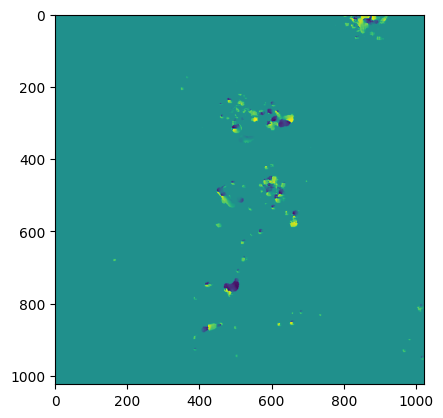

In [50]:
flow_2d = np.max(flow, axis=1)

angles = np.arctan2(flow_2d[1,...], flow_2d[2,...])
plt.figure()
plt.imshow(angles)

In [51]:
def calc_flow(img0, img1):
    flow = of(img0, img1, radius=5)
    flow_2d = np.max(flow, axis=1)
    angles = np.arctan2(flow_2d[1,...], flow_2d[2,...])
    return angles

In [52]:
angle_set = []

for t in tqdm(range(0, data_smoothed.shape[0])):
    angles = calc_flow(data_smoothed[t,0,...], data_smoothed[t+1,0,...])
    
    angle_set.append(angles)
    


 99%|█████████▉| 187/188 [1:44:09<00:33, 33.42s/it]


IndexError: index 188 is out of bounds for axis 0 with size 188

In [53]:
angle_set = np.stack(angle_set, axis=0)

OmeTiffWriter.save(angle_set, 'results/angle_set.tiff', dim_order='TYX')